## Importance sampling: Selection of the proposal distribution


**<code>Code</code> from session 13.1 of CS146 course.**


In the previous session, you saw the posterior distribution below for estimating the unknown mean and standard deviation in a Gaussian mixture model. [See the previous pre-class work](https://gist.github.com/cscheffler/b0a31f9a2749804ac1268d9ab20ffa7f) for the model details, if you need to refresh your memory.

$$p(\mu, \sigma\,|\,\{x\}) \propto \underbrace{\Bigg.\text{Normal}(\mu\,|\,0, 5^2)\,\text{Gamma}(\sigma\,|\,2, 1)}_{\text{prior}}\, \underbrace{\prod_{i=1}^{20} \big[0.7\text{Normal}(x_i\,|\,0,4^2) + 0.3\text{Normal}(x_i\,|\,\mu,\sigma^2)\big]}_{\text{likelihood}}$$

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
# The data set from the model specification
data = [
  -4.127935, -2.152332, 3.046302, -10.77442, -6.985155, 5.536106, 1.294746,
  7.638998, -5.650118, -4.478067, -0.4551435, -3.969413, -0.4225518, -2.462094,
  1.886675, 3.095567, 4.310003, 3.305034, 0.8548273, 4.368213]

# The unnormalized posterior distribution function, as defined above.
def unnormalized_posterior(mu, sigma, data):
    if sigma < 0:
        # The probably of sigma < 0 is 0. It will become clear why we need this
        # a little further down – samples from our proposal distribution might
        # have sigma < 0.
        return 0
    else:
        return (
            sts.norm.pdf(mu, loc=0, scale=5) *
            sts.gamma.pdf(sigma, a=2, scale=1) *
            np.prod(
                0.7 * sts.norm.pdf(data, loc=0, scale=4) +
                0.3 * sts.norm.pdf(data, loc=mu, scale=sigma)))

C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\scipy\stats\_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


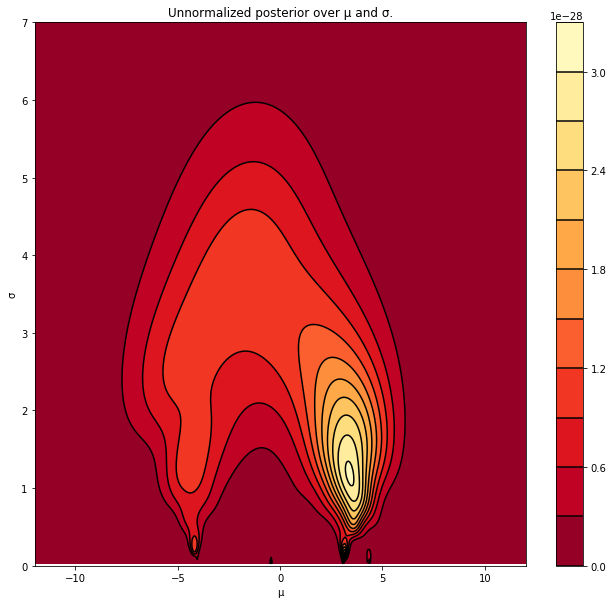

In [3]:
# Plot of the unormalized posterior using a 2-d contour plot.
plot_mu_range = [-12, 12]
plot_sigma_range = [0, 7]

mu = np.linspace(plot_mu_range[0], plot_mu_range[1], 300)
sigma = np.linspace(plot_sigma_range[0], plot_sigma_range[1], 300)
posterior = np.empty((len(sigma), len(mu)))
for i in range(len(sigma)):
    for j in range(len(mu)):
        posterior[i,j] = unnormalized_posterior(mu[j], sigma[i], data)

plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

## Defensive sampling

Here we use the bad bimodal proposal distribution that you saw in the pre-class work. We mix in a little bit (5%) of the prior distribution for this model. Note that with 100,000 samples, this means that only about 5,000 samples will come from the prior whereas 995,000 will still come from the bad bimodal proposal distribution.

In [4]:
# Proposal distribution: Bimodal. A mixture of two normal distributions over mu
# with means at -4 and 4. A single normal distribution over sigma.

# Probability density function of the bimodal proposal distribution
def bimodal_pdf(mu, sigma):
    return (
        (
            0.5 * sts.norm.pdf(mu, loc=4, scale=1.5) +
            0.5 * sts.norm.pdf(mu, loc=-4, scale=1.5)) *
        sts.norm.pdf(sigma, loc=1.5, scale=0.75))

# Generate samples from the bimodal proposal distribution
def bimodal_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.5, size=size)    
    mu_samples = (
        selector * sts.norm.rvs(loc=4, scale=1.5, size=size) +
        (1-selector) * sts.norm.rvs(loc=-4, scale=1.5, size=size))

    # Repeatedly sample sigmas until they are all greater than 0.
    sigma_samples = np.zeros(size)
    while True:
        not_positive = sigma_samples <= 0
        how_many = sum(not_positive)
        if how_many == 0:
            break
        sigma_samples[not_positive] = sts.norm.rvs(loc=1.5, scale=0.75, size=how_many)

    return {
        'mu': mu_samples,
        'sigma': sigma_samples}


# Proposal distribution: Prior.

# Probability density function of the prior distribution.
def prior_pdf(mu, sigma):
    return (
        sts.norm.pdf(mu, loc=0, scale=5) *
        sts.gamma.pdf(sigma, a=2, scale=1))

# Generate samples from the prior distribution.
def prior_rvs(size):
    mu_samples = sts.norm.rvs(loc=0, scale=5, size=size)
    sigma_samples = sts.gamma.rvs(a=2, scale=1, size=size)
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}


# Proposal distribution: Defensive. This is a mixture of 0.95 of the bimodal
# distribution and 0.05 of the prior distribution.

# Probability density function of the defensive proposal distribution.
def defensive_pdf(mu, sigma):
    return 0.95 * bimodal_pdf(mu, sigma) + 0.05 * prior_pdf(mu, sigma)

# Generate samples from the defensive proposal distribution.
def defensive_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.95, size=size)
    bimodal_samples = bimodal_rvs(size)
    prior_samples = prior_rvs(size)
    mu_samples = (
        selector * bimodal_samples['mu'] +
        (1-selector) * prior_samples['mu'])
    sigma_samples = (
        selector * bimodal_samples['sigma'] +
        (1-selector) * prior_samples['sigma'])
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}

In [5]:
# Generate samples
num_samples = 100000
proposal_distribution = defensive_pdf
proposal_samples = defensive_rvs(num_samples)

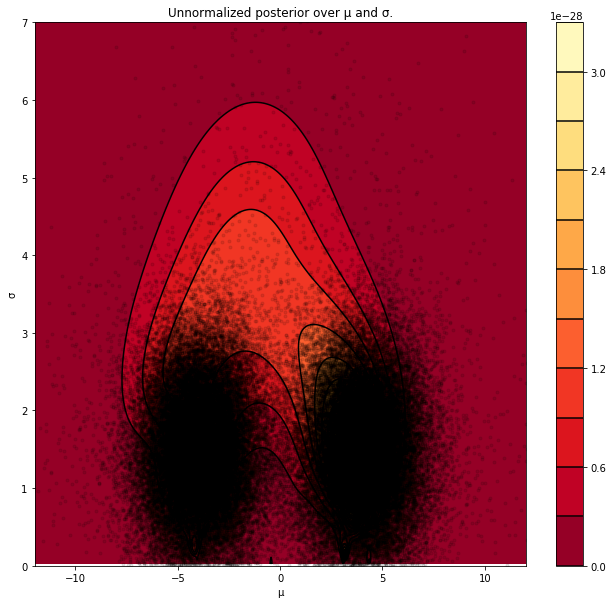

In [6]:
# Plot of the samples on the level plot
plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(proposal_samples['mu'], proposal_samples['sigma'], 'k.', alpha=0.1)
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
plt.xlim(plot_mu_range[0], plot_mu_range[1])
plt.ylim(plot_sigma_range[0], plot_sigma_range[1])
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

In [7]:
# Calculate the importance weights, p(sample) / q(sample)
weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(proposal_samples['mu'][i], proposal_samples['sigma'][i], data)
    q_value = proposal_distribution(proposal_samples['mu'][i], proposal_samples['sigma'][i])
    weights[i] = p_value / q_value

Estimate for σ² with 100000 samples: 10.87711519379177


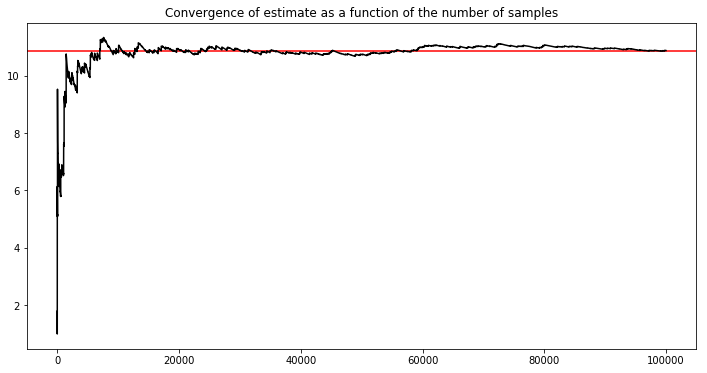

In [8]:
f_values = proposal_samples['sigma'] ** 2
estimate = np.sum(f_values * weights) / np.sum(weights)
print('Estimate for σ² with', num_samples, 'samples:', estimate)

convergence = np.cumsum(f_values * weights) / np.cumsum(weights)
plt.figure(figsize=(12, 6))
plt.axhline(estimate, color='red')
plt.plot(convergence, 'k-')
plt.title('Convergence of estimate as a function of the number of samples')
plt.show()

## Task 1

Even though most samples are still from the bad bimodal distribution, the importance sampler now converges to the correct expected value. Try to explain why this is.

The mix of prior and bimodal distribution resulted in the correct expected value. 

## Task 2

Rerun the importance sampler, but now using the prior distribution as the proposal distribution. This removes the bimodal distribution completely. Comment on the convergence of this importance sampler.

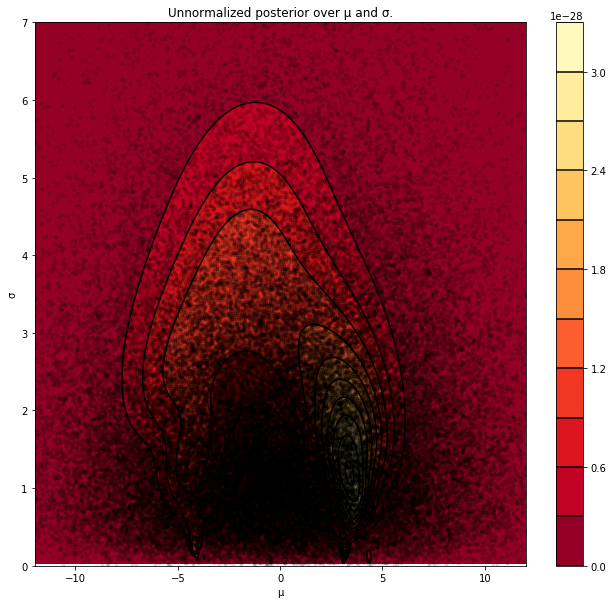

In [9]:
# Probability density function of the defensive proposal distribution.
def defensive_pdf(mu, sigma):
    return 0.00 * bimodal_pdf(mu, sigma) + 1.00 * prior_pdf(mu, sigma)

# def defensive_rvs(size):
#     mu_samples = sts.norm.rvs(loc=0, scale=5, size=size)
#     sigma_samples = sts.gamma.rvs(a=2, scale=1, size=size)
#     return {
#         'mu': mu_samples,
#         'sigma': sigma_samples}


def defensive_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.00, size=size)
    bimodal_samples = bimodal_rvs(size)
    prior_samples = prior_rvs(size)
    mu_samples = (
        selector * bimodal_samples['mu'] +
        (1-selector) * prior_samples['mu'])
    sigma_samples = (
        selector * bimodal_samples['sigma'] +
        (1-selector) * prior_samples['sigma'])
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}


# Generate samples
num_samples = 100000
proposal_distribution = defensive_pdf
proposal_samples = defensive_rvs(num_samples)

# Plot of the samples on the level plot
plt.figure(figsize=(11, 10))
filled = plt.contourf(mu, sigma, posterior, 11, cmap=plt.cm.YlOrRd_r)
lines = plt.contour(mu, sigma, posterior, 11, colors='black')
plt.plot(proposal_samples['mu'], proposal_samples['sigma'], 'k.', alpha=0.1)
plt.title('Unnormalized posterior over μ and σ.')
plt.xlabel('μ')
plt.ylabel('σ')
plt.xlim(plot_mu_range[0], plot_mu_range[1])
plt.ylim(plot_sigma_range[0], plot_sigma_range[1])
color_bar = plt.colorbar(filled)
color_bar.add_lines(lines)
plt.show()

In [10]:
# Calculate the importance weights, p(sample) / q(sample)
weights = np.empty(num_samples)
for i in range(num_samples):
    p_value = unnormalized_posterior(proposal_samples['mu'][i], proposal_samples['sigma'][i], data)
    q_value = proposal_distribution(proposal_samples['mu'][i], proposal_samples['sigma'][i])
    weights[i] = p_value / q_value

Estimate for σ² with 100000 samples: 10.762861149058324


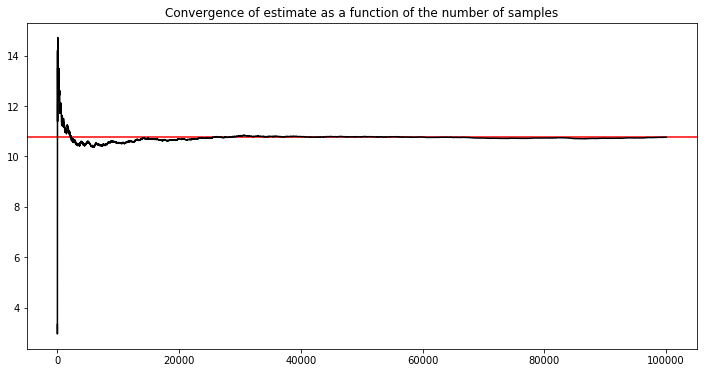

In [11]:
f_values = proposal_samples['sigma'] ** 2
estimate = np.sum(f_values * weights) / np.sum(weights)
print('Estimate for σ² with', num_samples, 'samples:', estimate)

convergence = np.cumsum(f_values * weights) / np.cumsum(weights)
plt.figure(figsize=(12, 6))
plt.axhline(estimate, color='red')
plt.plot(convergence, 'k-')
plt.title('Convergence of estimate as a function of the number of samples')
plt.show()

## Task 3

Calculate an approximate confidence interval over the estimate for $E[\sigma^2]$ using only 10,000 samples. Use the defensive proposal distribution and create a loop to compute the expectation 100 times. Using these 100 results, what is your 95% confidence interval over $E[\sigma^2]$ using 10,000 samples?

In [12]:
def bimodal_pdf(mu, sigma):
    return (
        (
            0.5 * sts.norm.pdf(mu, loc=4, scale=1.5) +
            0.5 * sts.norm.pdf(mu, loc=-4, scale=1.5)) *
        sts.norm.pdf(sigma, loc=1.5, scale=0.75))

# Generate samples from the bimodal proposal distribution
def bimodal_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.5, size=size)    
    mu_samples = (
        selector * sts.norm.rvs(loc=4, scale=1.5, size=size) +
        (1-selector) * sts.norm.rvs(loc=-4, scale=1.5, size=size))

    # Repeatedly sample sigmas until they are all greater than 0.
    sigma_samples = np.zeros(size)
    while True:
        not_positive = sigma_samples <= 0
        how_many = sum(not_positive)
        if how_many == 0:
            break
        sigma_samples[not_positive] = sts.norm.rvs(loc=1.5, scale=0.75, size=how_many)

    return {
        'mu': mu_samples,
        'sigma': sigma_samples}


# Proposal distribution: Prior.

# Probability density function of the prior distribution.
def prior_pdf(mu, sigma):
    return (
        sts.norm.pdf(mu, loc=0, scale=5) *
        sts.gamma.pdf(sigma, a=2, scale=1))

# Generate samples from the prior distribution.
def prior_rvs(size):
    mu_samples = sts.norm.rvs(loc=0, scale=5, size=size)
    sigma_samples = sts.gamma.rvs(a=2, scale=1, size=size)
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}


# Proposal distribution: Defensive. This is a mixture of 0.95 of the bimodal
# distribution and 0.05 of the prior distribution.

# Probability density function of the defensive proposal distribution.
def defensive_pdf(mu, sigma):
    return 0.95 * bimodal_pdf(mu, sigma) + 0.05 * prior_pdf(mu, sigma)

# Generate samples from the defensive proposal distribution.
def defensive_rvs(size):
    # Sample a vector of 0s and 1s, for picking from which normal to sample mu.
    selector = sts.bernoulli.rvs(0.95, size=size)
    bimodal_samples = bimodal_rvs(size)
    prior_samples = prior_rvs(size)
    mu_samples = (
        selector * bimodal_samples['mu'] +
        (1-selector) * prior_samples['mu'])
    sigma_samples = (
        selector * bimodal_samples['sigma'] +
        (1-selector) * prior_samples['sigma'])
    return {
        'mu': mu_samples,
        'sigma': sigma_samples}

In [14]:
# Generate 10000 samples for 100 interations
estimate = []
for _ in range(100):
    num_samples = 1000
    proposal_distribution = defensive_pdf
    proposal_samples = defensive_rvs(num_samples)

    weights = np.empty(num_samples)
    for i in range(num_samples):
        p_value = unnormalized_posterior(proposal_samples['mu'][i], proposal_samples['sigma'][i], data)
        q_value = proposal_distribution(proposal_samples['mu'][i], proposal_samples['sigma'][i])
        weights[i] = p_value / q_value
    
    f_values = proposal_samples['sigma'] ** 2
    estimate.append(np.sum(f_values * weights) / np.sum(weights))

In [15]:
sts.t.interval(0.95, len(estimate)-1, loc=np.mean(estimate), scale=sts.sem(estimate))

(9.808801504932175, 10.61892253822239)

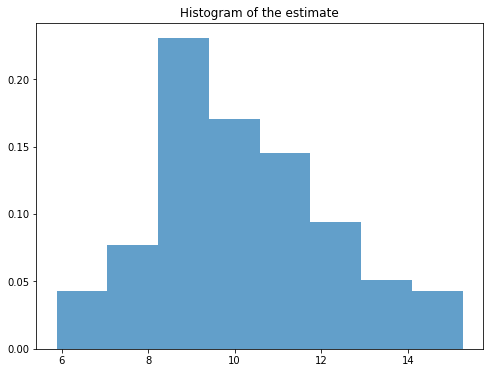

In [22]:
plt.figure(figsize=(8, 6))
plt.hist(estimate, bins='auto', density=True, alpha=0.7)
plt.title("Histogram of the estimate")
plt.show()